In [20]:
import matplotlib.pyplot as plt 
import MetaTrader5 as mt5
import tensorflow as tf
import numpy as np
import pandas as pd
import tf2onnx
from sklearn.model_selection import train_test_split
from sys import argv
from ta.trend import PSARIndicator

In [21]:
# Check tensorflow version
print(tf.__version__)

2.12.0


In [22]:
# Check GPU support
print(len(tf.config.list_physical_devices('GPU')) > 0)

False


In [23]:
# Initialize MetaTrader5 for history data
if not mt5.initialize():
    print("initialize() failed, error code =", mt5.last_error())
    quit()

In [24]:
# Show terminal info
terminal_info = mt5.terminal_info()
print(terminal_info)


TerminalInfo(community_account=True, community_connection=True, connected=True, dlls_allowed=False, trade_allowed=True, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=False, build=4468, maxbars=100000, codepage=0, ping_last=31129, community_balance=0.0, retransmission=0.4527024367200724, company='Exness Technologies Ltd', name='MetaTrader 5 EXNESS', language='English', path='C:\\Program Files\\MetaTrader 5 EXNESS', data_path='C:\\Users\\Msyne\\AppData\\Roaming\\MetaQuotes\\Terminal\\53785E099C927DB68A545C249CDBCE06', commondata_path='C:\\Users\\Msyne\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')


In [25]:
# Show file path
file_path = terminal_info.data_path + "\\MQL5\\Files\\"
print(file_path)

C:\Users\Msyne\AppData\Roaming\MetaQuotes\Terminal\53785E099C927DB68A545C249CDBCE06\MQL5\Files\


In [26]:
# Data path to save the model
data_path = argv[0]
last_index = data_path.rfind("\\") + 1
data_path = data_path[0:last_index]
print("data path to save onnx model", data_path)

data path to save onnx model C:\Users\Msyne\AppData\Roaming\Python\Python310\site-packages\


In [27]:
# Set start and end dates for history data
from datetime import timedelta, datetime
end_date = datetime.now()
start_date = end_date - timedelta(days=120)

In [28]:
# Print start and end dates
print("data start date =", start_date)
print("data end date =", end_date)

data start date = 2024-05-02 15:36:23.433932
data end date = 2024-08-30 15:36:23.433932


In [29]:
# Get XAUUSD rates (H1) from start_date to end_date
xauusd_rates = mt5.copy_rates_range("XAUUSDm", mt5.TIMEFRAME_H1, start_date, end_date)

In [30]:
# Check
print(xauusd_rates)

[(1714640400, 2304.074, 2305.38 , 2298.796, 2301.799, 5483, 199, 0)
 (1714644000, 2301.748, 2301.848, 2295.14 , 2299.227, 6587, 199, 0)
 (1714647600, 2299.282, 2302.969, 2297.513, 2299.008, 5826, 199, 0) ...
 (1724997600, 2513.805, 2524.103, 2513.107, 2517.768, 9759, 159, 0)
 (1725001200, 2517.743, 2521.379, 2517.512, 2519.369, 6148, 159, 0)
 (1725004800, 2519.356, 2526.763, 2518.834, 2526.456, 3771, 159, 0)]


In [31]:
# Create dataframe
df = pd.DataFrame(xauusd_rates)

In [32]:
# Calculate PSAR
psar_indicator = PSARIndicator(df['high'], df['low'], df['close'])
df['psar'] = psar_indicator.psar()

In [33]:
# Show dataframe head
df.head()

,time,open,high,low,close,tick_volume,spread,real_volume,psar
0,1714640400,2304.074,2305.380,2298.796,2301.799,5483,199,0,2301.799000
1,1714644000,2301.748,2301.848,2295.140,2299.227,6587,199,0,2299.227000
2,1714647600,2299.282,2302.969,2297.513,2299.008,5826,199,0,2305.380000
3,1714651200,2298.956,2304.462,2293.474,2294.465,10313,199,0,2305.222660
4,1714654800,2294.523,2295.769,2285.392,2291.587,16008,199,0,2304.752714


In [34]:
# Show dataframe tail
df.tail()

,time,open,high,low,close,tick_volume,spread,real_volume,psar
1964,1724990400,2513.533,2514.587,2512.140,2513.410,3967,159,0,2527.734790
1965,1724994000,2513.391,2516.314,2512.453,2513.810,5412,159,0,2526.799103
1966,1724997600,2513.805,2524.103,2513.107,2517.768,9759,159,0,2525.919557
1967,1725001200,2517.743,2521.379,2517.512,2519.369,6148,159,0,2525.092783
1968,1725004800,2519.356,2526.763,2518.834,2526.456,3771,159,0,2512.140000


In [35]:
# Show dataframe shape (the number of rows and columns in the dataset)
df.shape


(1969, 9)

In [36]:
# Prepare close prices and PSAR values
data = df[['close', 'psar']].values

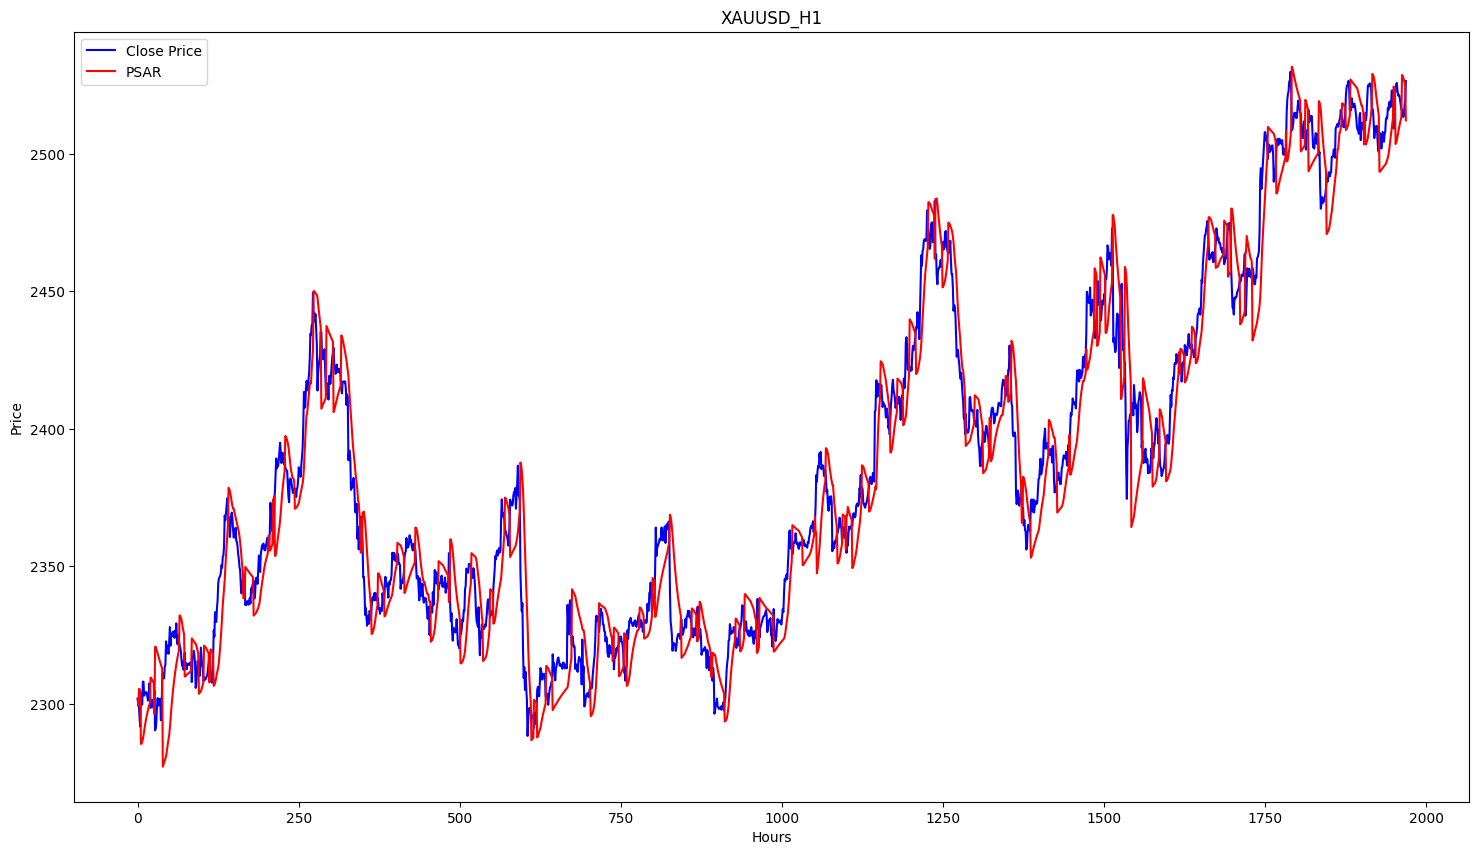

In [37]:
# Show close prices and PSAR values
plt.figure(figsize=(18,10))
plt.plot(data[:, 0], 'b', label='Close Price')
plt.plot(data[:, 1], 'r', label='PSAR')
plt.xlabel("Hours")
plt.ylabel("Price")
plt.title("XAUUSD_H1")
plt.legend()

In [38]:
# Scale data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [39]:
# Training size is 80% of the data
training_size = int(len(scaled_data) * 0.80)
print("training size:", training_size)

training size: 1575


In [40]:
# Create train data and check size
train_data_initial = scaled_data[0:training_size, :]
print(len(train_data_initial))

1575


In [41]:
# Create test data and check size
test_data_initial = scaled_data[training_size:, :]
print(len(test_data_initial))

394


In [42]:
# Split a multivariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # Find the end of this pattern
        end_ix = i + n_steps
        # Check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # Gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [43]:
# Split into samples
time_step = 120
x_train, y_train = split_sequence(train_data_initial, time_step)
x_test, y_test = split_sequence(test_data_initial, time_step)

In [44]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2])

In [45]:
# Show shape of train data
x_train.shape

(1455, 120, 2)

In [46]:
# Show shape of test data
x_test.shape

(274, 120, 2)

In [47]:
# Import keras libraries for the model
import math
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Dropout
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.metrics import RootMeanSquaredError as rmse
from keras import optimizers

In [48]:
# Define the model
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', padding='same', input_shape=(120, 2)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=[rmse()])

In [49]:
# Show model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 120, 256)          1280      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 60, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 60, 100)           142800    
_________________________________________________________________
dropout (Dropout)            (None, 60, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [50]:
# Measure time
import time 
time_calc_start = time.time()

In [51]:
# Fit model with 300 epochs
history = model.fit(x_train, y_train, epochs=300, validation_data=(x_test, y_test), batch_size=32, verbose=1)

Epoch 1/300
46/46 [==============================] - 12s 167ms/step - loss: 0.0249 - root_mean_squared_error: 0.1578 - val_loss: 0.0328 - val_root_mean_squared_error: 0.1812
Epoch 2/300
46/46 [==============================] - 7s 151ms/step - loss: 0.0046 - root_mean_squared_error: 0.0681 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1516
Epoch 3/300
46/46 [==============================] - 7s 151ms/step - loss: 0.0030 - root_mean_squared_error: 0.0547 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1428
Epoch 4/300
46/46 [==============================] - 7s 155ms/step - loss: 0.0021 - root_mean_squared_error: 0.0458 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904
Epoch 5/300
46/46 [==============================] - 7s 155ms/step - loss: 0.0018 - root_mean_squared_error: 0.0426 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1317
Epoch 6/300
46/46 [==============================] - 7s 160ms/step - loss: 0.0016 - root_mean_squared_error: 0.0406 - val_loss: 0.0124

In [52]:
# Calculate time
fit_time_seconds = time.time() - time_calc_start
print("fit time =", fit_time_seconds, " seconds.")

fit time = 2421.6557698249817  seconds.


In [53]:
# Show training history keys
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

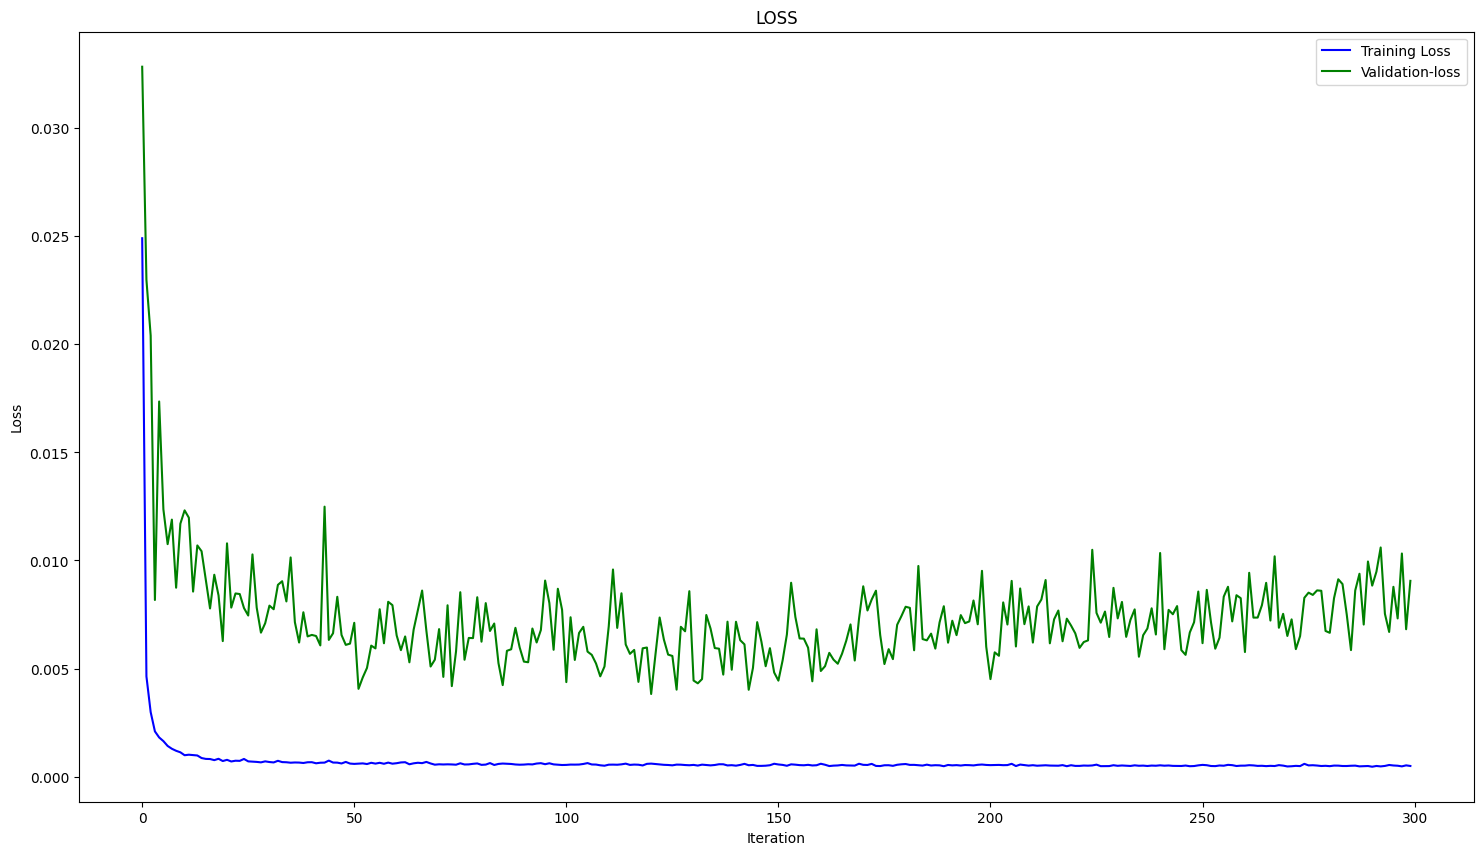

In [54]:
# Show iteration-loss graph for training and validation
plt.figure(figsize=(18,10))
plt.plot(history.history['loss'], label='Training Loss', color='b')
plt.plot(history.history['val_loss'], label='Validation-loss', color='g')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("LOSS")
plt.legend()

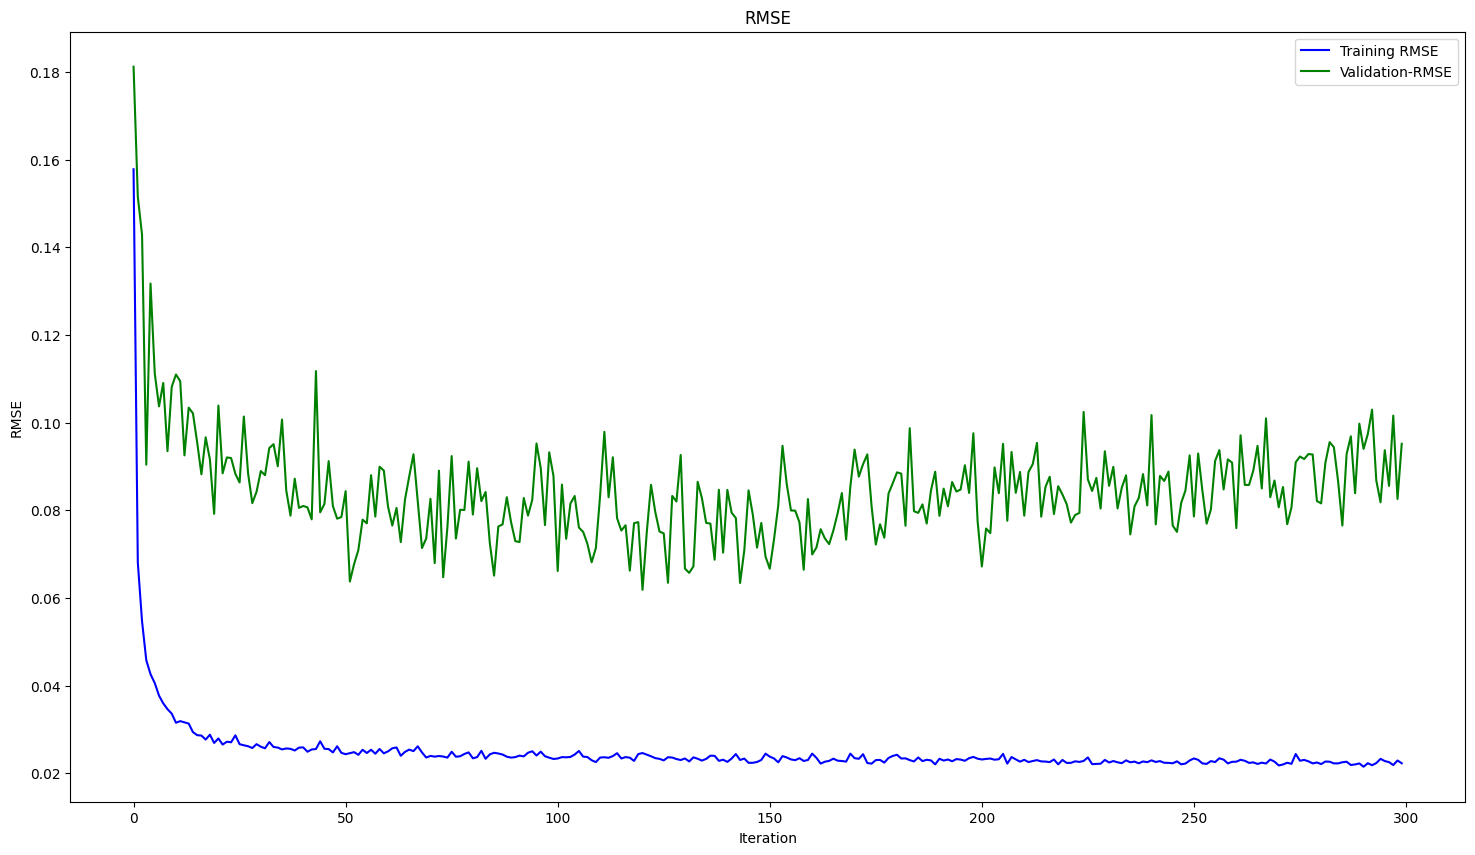

In [55]:
# Show iteration-rmse graph for training and validation
plt.figure(figsize=(18,10))
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE', color='b')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation-RMSE', color='g')
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("RMSE")
plt.legend()

In [56]:
# Evaluate training data
model.evaluate(x_train, y_train, batch_size=32)


46/46 [==============================] - 2s 52ms/step - loss: 3.4853e-04 - root_mean_squared_error: 0.0187


[0.00034853495890274644, 0.018669091165065765]

In [57]:
# Evaluate testing data
model.evaluate(x_test, y_test, batch_size=32)

9/9 [==============================] - 0s 47ms/step - loss: 0.0091 - root_mean_squared_error: 0.0952


[0.009058631025254726, 0.09517683833837509]

In [58]:
# Prediction using training data
train_predict = model.predict(x_train)
plot_y_train = y_train.reshape(-1, 1)

In [60]:
# Show actual vs predicted (training) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_train)[:, 0], color='b', label='Original')
plt.plot(scaler.inverse_transform(train_predict), color='red', label='Predicted')
plt.title("Prediction Graph Using Training Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.legend()
plt.show()

ValueError: non-broadcastable output operand with shape (1455,1) doesn't match the broadcast shape (1455,2)

<Figure size 1800x1000 with 0 Axes>

In [61]:
# Prediction using testing data
test_predict = model.predict(x_test)
plot_y_test = y_test.reshape(-1, 1)

In [62]:
# Calculate metrics
from sklearn import metrics
from sklearn.metrics import r2_score

In [63]:
# Transform data to real values
value1 = scaler.inverse_transform(plot_y_test)[:, 0]
value2 = scaler.inverse_transform(test_predict)

ValueError: non-broadcastable output operand with shape (274,1) doesn't match the broadcast shape (274,2)

In [64]:
# Calculate score
score = np.sqrt(metrics.mean_squared_error(value1, value2))
print("RMSE         : {}".format(score))
print("MSE          :", metrics.mean_squared_error(value1, value2))
print("R2 score     :", metrics.r2_score(value1, value2))

NameError: name 'value1' is not defined

In [65]:
# Show actual vs predicted (testing) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_test)[:, 0], color='b', label='Original')
plt.plot(scaler.inverse_transform(test_predict), color='g', label='Predicted')
plt.title("Prediction Graph Using Testing Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.legend()
plt.show()

ValueError: non-broadcastable output operand with shape (274,1) doesn't match the broadcast shape (274,2)

<Figure size 1800x1000 with 0 Axes>

In [66]:
# Save model to ONNX
output_path = data_path + "model.xauusd.H1.PSAR.120.onnx"
onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)
print(f"model saved to {output_path}")

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
model saved to C:\Users\Msyne\AppData\Roaming\Python\Python310\site-packages\model.xauusd.H1.PSAR.120.onnx


In [67]:
output_path = file_path + "model.xauusd.H1.PSAR.120.onnx"
onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)
print(f"saved model to {output_path}")

saved model to C:\Users\Msyne\AppData\Roaming\MetaQuotes\Terminal\53785E099C927DB68A545C249CDBCE06\MQL5\Files\model.xauusd.H1.PSAR.120.onnx


In [68]:
# Finish
mt5.shutdown()

True